In [44]:
import setproctitle

setproctitle.setproctitle("alex_best_model")

In [45]:
import gc
import os
import sys
import time

import catboost
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

tqdm.pandas()

In [3]:
cat_features = [
    "emp_title",
    "home_ownership",
    "verification_status",
    "purpose",
    "zip_code",
    "addr_state",
    "initial_list_status",
    "application_type",
    "verification_status_joint",
    "disbursement_method",
]

In [62]:
samples = {
    k: pd.read_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_{k}.parquet") for k in ["train", "oos", "oot"]
}

In [63]:
features = sorted(set(samples["train"].columns) - {"target", "issue_d", "last_pymnt_d", "next_pymnt_d",
                                                  "int_rate", "term", "installment", "funded_amnt", "loan_amnt","dti"
                                                  })

In [64]:
pools = {
    k: catboost.Pool(v[v["target"] != -1][features], v[v["target"] != -1]["target"], cat_features=cat_features)
    for k, v in samples.items()
}
# pools['train'].quantize()
# pools['train'].save_quantization_borders('borders.dat')
# pools['oos'].quantize(input_borders='borders.dat')
# pools['oot'].quantize(input_borders='borders.dat')

# Train best model

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

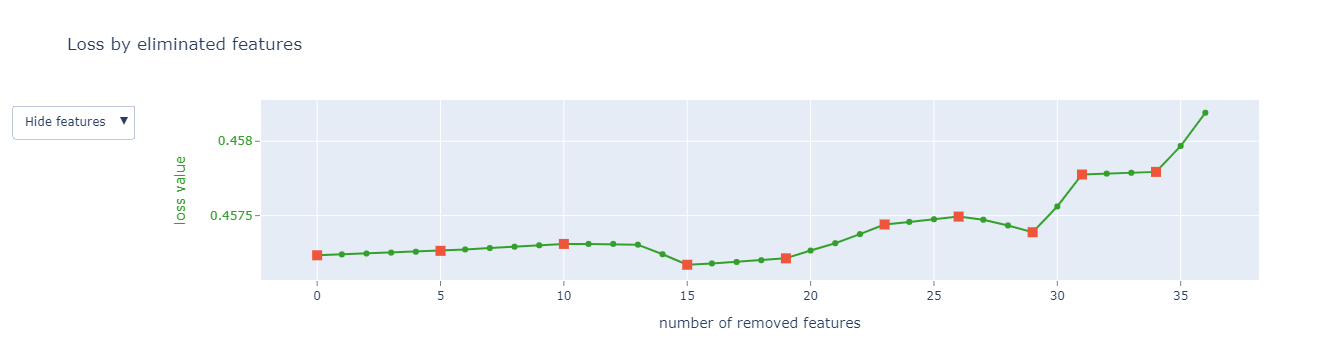

In [65]:
clf = catboost.CatBoostClassifier(
    iterations=400,
    max_depth=4,
    learning_rate=0.1,
    rsm=0.7,
    od_wait=100,
    use_best_model=True,
    eval_metric="AUC:hints=skip_train~false",
    logging_level="Silent",
)
summary = clf.select_features(
    pools["train"],
    eval_set=pools["oos"],
    features_for_select=np.arange(len(features)),
    steps=10,
    num_features_to_select=20,
    verbose=0,
    plot=True,
    train_final_model=False,
)

In [66]:
features = summary["selected_features_names"] + [
    name
    for name, a, b in zip(
        summary["eliminated_features_names"],
        summary["loss_graph"]["loss_values"],
        summary["loss_graph"]["loss_values"][1:],
    )
    if b - a > 0.00001
]
ignored_features = sorted(set(pools['train'].get_feature_names()) - set(features))
len(features)

33

In [67]:
pools = {
    k: catboost.Pool(v[v["target"] != -1][features], v[v["target"] != -1]["target"], cat_features=sorted(set(cat_features) & set(features)))
    for k, v in samples.items()
}

In [68]:
def objective2(trial):
    params = {
        "iterations": 400,
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.2),
        "depth": trial.suggest_int("depth", 1, 6),
        "grow_policy": "SymmetricTree",
        "od_wait": 50,
        "eval_metric": "AUC",
        "logging_level": "Silent",
    }
    if params["grow_policy"] != "Depthwise":
        extra = {
            "rsm": trial.suggest_float("rsm", 0.1, 1.0),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0),
            # "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
            "random_strength": trial.suggest_float("random_strength", 0.1, 10.0),
            # "langevin": trial.suggest_categorical("langevin", [True, False]),
        }
        params = {**params, **extra}
    clf = catboost.CatBoostClassifier(
        **params,
    )

    clf.fit(
        pools["train"],
        eval_set=pools["oos"],
        verbose=0,
        plot=False,
    )
    x = samples["oos"][samples["oos"]["target"] != -1]
    proba = clf.predict_proba(x[features])[:, 1]
    return roc_auc_score(x['target'], proba)

In [ ]:
storage = optuna.storages.RDBStorage("sqlite:///catboost.db")
study = optuna.create_study(
    storage=storage,
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="catboost_02",
    direction="maximize",
    load_if_exists=True,
)
study.optimize(objective2, n_trials=40)

[I 2022-06-08 22:09:35,025] A new study created in RDB with name: catboost_02
[I 2022-06-08 22:12:16,435] Trial 0 finished with value: 0.7075131986438284 and parameters: {'learning_rate': 0.09367182020405163, 'depth': 6, 'rsm': 0.7587945476302645, 'l2_leaf_reg': 30.334265725654795, 'random_strength': 1.6445845403801216}. Best is trial 0 with value: 0.7075131986438284.
[I 2022-06-08 22:12:52,493] Trial 1 finished with value: 0.6652036086942572 and parameters: {'learning_rate': 0.05651906845715445, 'depth': 1, 'rsm': 0.8795585311974417, 'l2_leaf_reg': 30.45463557541723, 'random_strength': 7.10991852018085}. Best is trial 0 with value: 0.7075131986438284.
[I 2022-06-08 22:15:38,861] Trial 2 finished with value: 0.6914653525211784 and parameters: {'learning_rate': 0.033499364030286416, 'depth': 6, 'rsm': 0.8491983767203796, 'l2_leaf_reg': 11.404616423235531, 'random_strength': 1.9000671753502962}. Best is trial 0 with value: 0.7075131986438284.
[I 2022-06-08 22:16:29,808] Trial 3 finished 